## 6. 코호트 분석 : 가입 시기별 이탈 정도
### 6-0. 기본 세팅

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import copy

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = 'C:\\Windows\\Fonts\\NanumBarunGothicLight.ttf'
font = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family='NanumBarunGothic')

### 6-1. 데이터 로드

In [ ]:
data = pd.read_csv('data_230511.csv').sort_values('created_at', ascending=False).reset_index(drop=True)
data.head()

,customer_id,created_at,pre_discount,post_discount,cashback_amount,discount_amount,total_promotion,push_permission,gender,is_foreigner,...,merchant_id,age,c_year,c_month,c_hour,discount_ratio,cashback_ratio,promo_ratio,count,class
0,250787,2020-03-31 23:59:14.018,539,539,10,0,10,True,male,False,...,6,31,2020,3,23,0.0,0.02,0.02,180,vip
1,94814,2020-03-31 23:59:11.789,8300,8300,415,0,415,True,female,False,...,3,29,2020,3,23,0.0,0.05,0.05,8,general
2,16192,2020-03-31 23:59:04.295,28160,28160,1407,0,1407,False,female,False,...,4,38,2020,3,23,0.0,0.05,0.05,102,vip
3,249349,2020-03-31 23:58:55.267,20000,20000,1000,0,1000,True,female,False,...,9,37,2020,3,23,0.0,0.05,0.05,75,general
4,413401,2020-03-31 23:58:51.744,9800,9800,490,0,490,False,female,False,...,5,36,2020,3,23,0.0,0.05,0.05,21,general


In [ ]:
data['created_at'] = pd.to_datetime(data['created_at'])
data['sign_up_date'] = pd.to_datetime(data['sign_up_date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5623810 entries, 0 to 5623809
Data columns (total 22 columns):
 #   Column           Dtype         
---  ------           -----         
 0   customer_id      int64         
 1   created_at       datetime64[ns]
 2   pre_discount     int64         
 3   post_discount    int64         
 4   cashback_amount  int64         
 5   discount_amount  int64         
 6   total_promotion  int64         
 7   push_permission  bool          
 8   gender           object        
 9   is_foreigner     bool          
 10  birthday         object        
 11  sign_up_date     datetime64[ns]
 12  merchant_id      int64         
 13  age              int64         
 14  c_year           int64         
 15  c_month          int64         
 16  c_hour           int64         
 17  discount_ratio   float64       
 18  cashback_ratio   float64       
 19  promo_ratio      float64       
 20  count            int64         
 21  class            object        

In [ ]:
# 사용할 컬럼
cohort_df = data[['customer_id', 'sign_up_date', 'created_at']]
cohort_df

,customer_id,sign_up_date,created_at
0,250787,2019-10-21,2020-03-31 23:59:14.018
1,94814,2020-03-03,2020-03-31 23:59:11.789
2,16192,2019-10-18,2020-03-31 23:59:04.295
3,249349,2019-06-14,2020-03-31 23:58:55.267
4,413401,2019-07-09,2020-03-31 23:58:51.744
...,...,...,...
5623805,194227,2019-07-22,2019-08-01 00:32:57.712
5623806,424964,2019-07-10,2019-08-01 00:32:57.680
5623807,210615,2019-06-17,2019-08-01 00:32:57.160
5623808,13015,2019-07-18,2019-08-01 00:32:56.346


### 6-2. 파생변수 생성

In [ ]:
# 가입일자 -> 월
cohort_df['sign_month'] = cohort_df['sign_up_date'].apply(lambda x : dt.datetime.strftime(x, '%Y-%m'))
cohort_df

C:\Users\Y\AppData\Local\Temp\ipykernel_22692\928020301.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort_df['sign_month'] = cohort_df['sign_up_date'].apply(lambda x : dt.datetime.strftime(x, '%Y-%m'))


,customer_id,sign_up_date,created_at,sign_month
0,250787,2019-10-21,2020-03-31 23:59:14.018,2019-10
1,94814,2020-03-03,2020-03-31 23:59:11.789,2020-03
2,16192,2019-10-18,2020-03-31 23:59:04.295,2019-10
3,249349,2019-06-14,2020-03-31 23:58:55.267,2019-06
4,413401,2019-07-09,2020-03-31 23:58:51.744,2019-07
...,...,...,...,...
5623805,194227,2019-07-22,2019-08-01 00:32:57.712,2019-07
5623806,424964,2019-07-10,2019-08-01 00:32:57.680,2019-07
5623807,210615,2019-06-17,2019-08-01 00:32:57.160,2019-06
5623808,13015,2019-07-18,2019-08-01 00:32:56.346,2019-07


In [ ]:
# 마지막 구매일
last_purchase = pd.DataFrame(cohort_df.groupby('customer_id').head(1))
last_purchase.rename(columns={'created_at':'last_purchase'}, inplace=True)
last_purchase['last_purchase'] = pd.to_datetime(last_purchase['last_purchase'])

last_purchase['last_purchase_month'] = last_purchase['last_purchase'].apply(lambda x : dt.datetime.strftime(x, '%Y-%m'))

last_purchase


,customer_id,sign_up_date,last_purchase,sign_month,last_purchase_month
0,250787,2019-10-21,2020-03-31 23:59:14.018,2019-10,2020-03
1,94814,2020-03-03,2020-03-31 23:59:11.789,2020-03,2020-03
2,16192,2019-10-18,2020-03-31 23:59:04.295,2019-10,2020-03
3,249349,2019-06-14,2020-03-31 23:58:55.267,2019-06,2020-03
4,413401,2019-07-09,2020-03-31 23:58:51.744,2019-07,2020-03
...,...,...,...,...,...
5623741,207589,2019-08-01,2019-08-01 00:33:53.504,2019-08,2019-08
5623760,103513,2019-08-01,2019-08-01 00:33:32.039,2019-08,2019-08
5623774,90046,2019-08-01,2019-08-01 00:33:25.038,2019-08,2019-08
5623796,33583,2019-08-01,2019-08-01 00:33:05.252,2019-08,2019-08


In [ ]:
# customer_id 기준 left join
cohort_df = cohort_df.merge(last_purchase[['customer_id', 'last_purchase','last_purchase_month']], on='customer_id', how='left')
cohort_df.head()

,customer_id,sign_up_date,created_at,sign_month,last_purchase,last_purchase_month
0,250787,2019-10-21,2020-03-31 23:59:14.018,2019-10,2020-03-31 23:59:14.018,2020-03
1,94814,2020-03-03,2020-03-31 23:59:11.789,2020-03,2020-03-31 23:59:11.789,2020-03
2,16192,2019-10-18,2020-03-31 23:59:04.295,2019-10,2020-03-31 23:59:04.295,2020-03
3,249349,2019-06-14,2020-03-31 23:58:55.267,2019-06,2020-03-31 23:58:55.267,2020-03
4,413401,2019-07-09,2020-03-31 23:58:51.744,2019-07,2020-03-31 23:58:51.744,2020-03


In [ ]:
cohort_df.isnull().sum()

customer_id            0
sign_up_date           0
created_at             0
sign_month             0
last_purchase          0
last_purchase_month    0
dtype: int64

In [ ]:
# # 두번째 구매일자
# # 고객별 첫번째 구매일자를 제외하고 가장 빠른 날짜
# tmp = cohort_df[cohort_df['created_at'] != cohort_df['first_purchase']]

# second_purchase = pd.DataFrame(tmp.groupby('customer_id').head(1))
# second_purchase.rename(columns={'created_at':'second_purchase'}, inplace=True)
# second_purchase['second_purchase'] = pd.to_datetime(second_purchase['second_purchase'])

# second_purchase['second_purchase_month'] = second_purchase['second_purchase'].apply(lambda x : dt.datetime.strftime(x, '%Y-%m'))

# second_purchase


In [ ]:
# # customer_id 기준 left join
# cohort_df = cohort_df.merge(second_purchase[['customer_id', 'second_purchase', 'second_purchase_month']], on='customer_id', how='left')
# cohort_df.head()

In [ ]:
# cohort_df.isnull().sum()

In [ ]:
cohort_df.to_csv('cohort_signup_month_df.csv', index=False)

In [ ]:
# cohort_df = pd.read_csv('cohort_signup_month_df.csv')

- 제일 왼쪽 열이 행별 sum이어야 할 것 같은데...
- 지금 데이터상으로는 첫구매한 달에 다시 재구매를 한 사람

- 세로방향으로 보면, 같은 기간이 지난 후 cohort간 리텐션 비교
- 대각성방향으로 보면, 같은 시간의 cohort 간 비교(제일 바깥 대각선은 2020-03에 재구매를 한 사람들의 비율)

0. 재구매가 없는(즉, 한 번만 이용한) 고객 데이터는 제외
1. 2019년 8월에 첫구매한 사람의 22.1가 한 달뒤 차이페이를 재사용했다는 의미
2. 주로 한 달이내 재구매하는 듯

### 6-3. 경과 기간 계산

In [ ]:
# 시점 데이터 사전 만들기 ->  기간 계산 목적

month_dict = {}
i = 0
for month in sorted(cohort_df['sign_month'].unique()):
    month_dict[month] = i 
    i += 1
month_dict


{'2019-05': 0,
 '2019-06': 1,
 '2019-07': 2,
 '2019-08': 3,
 '2019-09': 4,
 '2019-10': 5,
 '2019-11': 6,
 '2019-12': 7,
 '2020-01': 8,
 '2020-02': 9,
 '2020-03': 10}

In [ ]:
cohort_df = cohort_df.dropna()

In [ ]:
# 경과기간 계산하기
cohort_df['period_month'] = cohort_df['last_purchase_month'].apply(lambda x : month_dict[x]) - cohort_df['sign_month'].apply(lambda x : month_dict[x])
cohort_df.head()

,customer_id,sign_up_date,created_at,sign_month,last_purchase,last_purchase_month,period_month
0,250787,2019-10-21,2020-03-31 23:59:14.018,2019-10,2020-03-31 23:59:14.018,2020-03,5
1,94814,2020-03-03,2020-03-31 23:59:11.789,2020-03,2020-03-31 23:59:11.789,2020-03,0
2,16192,2019-10-18,2020-03-31 23:59:04.295,2019-10,2020-03-31 23:59:04.295,2020-03,5
3,249349,2019-06-14,2020-03-31 23:58:55.267,2019-06,2020-03-31 23:58:55.267,2020-03,9
4,413401,2019-07-09,2020-03-31 23:58:51.744,2019-07,2020-03-31 23:58:51.744,2020-03,8


In [ ]:
cohort_data = cohort_df[['customer_id', 'sign_month', 'last_purchase_month', 'period_month']]
cohort_data

,customer_id,sign_month,last_purchase_month,period_month
0,250787,2019-10,2020-03,5
1,94814,2020-03,2020-03,0
2,16192,2019-10,2020-03,5
3,249349,2019-06,2020-03,9
4,413401,2019-07,2020-03,8
...,...,...,...,...
5623805,194227,2019-07,2020-03,8
5623806,424964,2019-07,2020-03,8
5623807,210615,2019-06,2020-03,9
5623808,13015,2019-07,2020-03,8


### 6-4. 가입시기별 grouping/count

In [ ]:
def get_unique_no(x):
    return len(np.unique(x))

cohort_group = cohort_data.groupby(['sign_month', 'period_month'])
cohort_group_df = cohort_group['customer_id'].apply(get_unique_no).reset_index()
cohort_group_df

,sign_month,period_month,customer_id
0,2019-05,4,1
1,2019-05,5,1
2,2019-05,6,1
3,2019-05,7,3
4,2019-05,8,2
5,2019-05,9,2
6,2019-05,10,14
7,2019-06,2,4310
8,2019-06,3,3167
9,2019-06,4,3704


In [ ]:
cohort_group_df.to_csv('cohort_signup_period_data.csv', index=False)

### 6-5. 시각화 위한 정리

In [ ]:
pd.DataFrame(cohort_group_df.groupby('sign_month')['customer_id'].sum())

,customer_id
sign_month,
2019-05,24
2019-06,74646
2019-07,78063
2019-08,110997
2019-09,36177
2019-10,48319
2019-11,40086
2019-12,51732
2020-01,56205


In [ ]:
cohort_group_df = cohort_group_df.pivot(index='sign_month', columns='period_month')
customer_cohort = cohort_group_df.div(cohort_group_df.iloc[:, 0], axis=0) *100
customer_cohort = customer_cohort.round(decimals=2)


In [ ]:
customer_cohort

customer_id                                                      \
period_month          0      1      2       3       4       5      6      7    
sign_month                                                                     
2019-05              NaN    NaN    NaN     NaN     NaN     NaN    NaN    NaN   
2019-06              NaN    NaN    NaN     NaN     NaN     NaN    NaN    NaN   
2019-07              NaN    NaN    NaN     NaN     NaN     NaN    NaN    NaN   
2019-08            100.0  13.73  12.62   14.41   14.74   31.66  43.49  77.64   
2019-09            100.0  22.59  19.24   18.08   34.49   46.12  96.51    NaN   
2019-10            100.0  35.10  30.14   48.81   60.88  102.08    NaN    NaN   
2019-11            100.0  34.45  49.37   64.36  110.98     NaN    NaN    NaN   
2019-12            100.0  52.76  66.35  111.42     NaN     NaN    NaN    NaN   
2020-01            100.0  46.59  68.79     NaN     NaN     NaN    NaN    NaN   
2020-02            100.0  59.18    NaN     NaN     NaN     NaN    NaN    NaN   
2020-03            100.0    NaN    NaN     NaN     NaN     NaN    NaN    NaN   

                          
period_month  8   9   10  
sign_month                
2019-05      NaN NaN NaN  
2019-06      NaN NaN NaN  
2019-07      NaN NaN NaN  
2019-08      NaN NaN NaN  
2019-09      NaN NaN NaN  
2019-10      NaN NaN NaN  
2019-11      NaN NaN NaN  
2019-12      NaN NaN NaN  
2020-01      NaN NaN NaN  
2020-02      NaN NaN NaN  
2020-03      NaN NaN NaN

In [ ]:
customer_cohort

customer_id                                                      \
period_month          0      1      2       3       4       5      6      7    
sign_month                                                                     
2019-05              NaN    NaN    NaN     NaN     NaN     NaN    NaN    NaN   
2019-06              NaN    NaN    NaN     NaN     NaN     NaN    NaN    NaN   
2019-07              NaN    NaN    NaN     NaN     NaN     NaN    NaN    NaN   
2019-08            100.0  13.73  12.62   14.41   14.74   31.66  43.49  77.64   
2019-09            100.0  22.59  19.24   18.08   34.49   46.12  96.51    NaN   
2019-10            100.0  35.10  30.14   48.81   60.88  102.08    NaN    NaN   
2019-11            100.0  34.45  49.37   64.36  110.98     NaN    NaN    NaN   
2019-12            100.0  52.76  66.35  111.42     NaN     NaN    NaN    NaN   
2020-01            100.0  46.59  68.79     NaN     NaN     NaN    NaN    NaN   
2020-02            100.0  59.18    NaN     NaN     NaN     NaN    NaN    NaN   
2020-03            100.0    NaN    NaN     NaN     NaN     NaN    NaN    NaN   

                          
period_month  8   9   10  
sign_month                
2019-05      NaN NaN NaN  
2019-06      NaN NaN NaN  
2019-07      NaN NaN NaN  
2019-08      NaN NaN NaN  
2019-09      NaN NaN NaN  
2019-10      NaN NaN NaN  
2019-11      NaN NaN NaN  
2019-12      NaN NaN NaN  
2020-01      NaN NaN NaN  
2020-02      NaN NaN NaN  
2020-03      NaN NaN NaN

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 [Text(0, 0.5, '2019-05'),
  Text(0, 1.5, '2019-06'),
  Text(0, 2.5, '2019-07'),
  Text(0, 3.5, '2019-08'),
  Text(0, 4.5, '2019-09'),
  Text(0, 5.5, '2019-10'),
  Text(0, 6.5, '2019-11'),
  Text(0, 7.5, '2019-12'),
  Text(0, 8.5, '2020-01'),
  Text(0, 9.5, '2020-02'),
  Text(0, 10.5, '2020-03')])

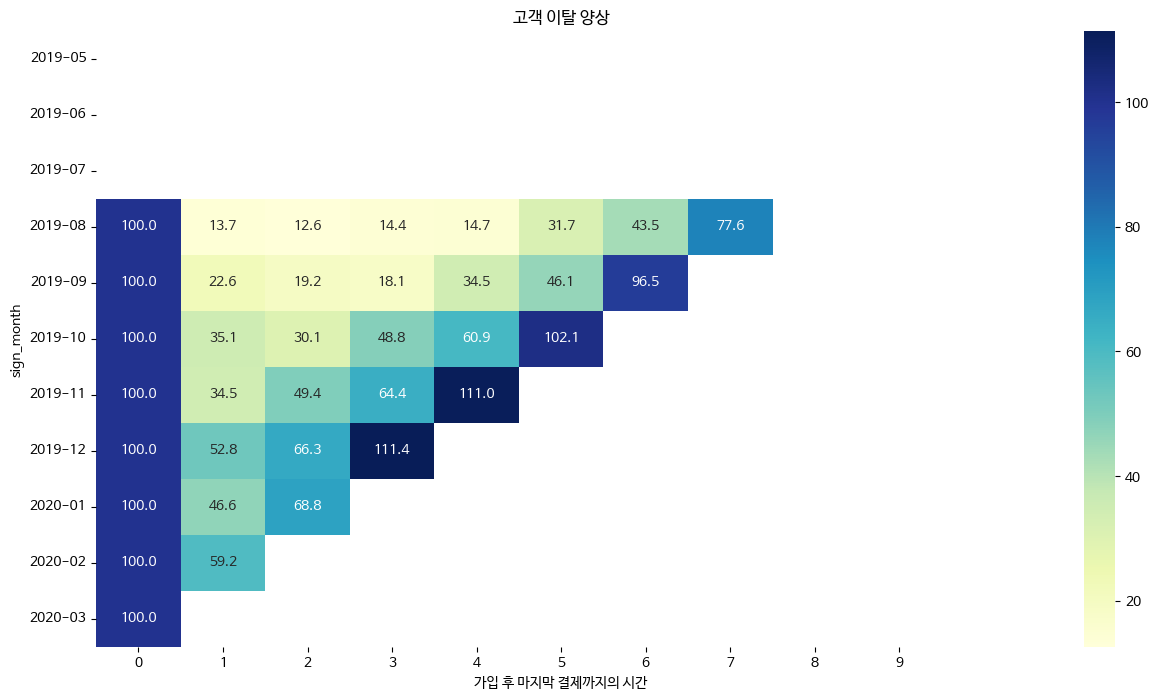

In [ ]:
import seaborn as sns

# 히트맵 시각화
xticks = np.arange(0, 10)
yticks = cohort_df['sign_month'].sort_values().unique().tolist()


plt.figure(figsize = (15, 8))
sns.heatmap(customer_cohort, 
            annot=True, 
            xticklabels=xticks,
            yticklabels=yticks, 
            fmt='.1f',
            cmap='YlGnBu')
plt.title('고객 이탈 양상')
plt.xlabel('가입 후 마지막 결제까지의 시간')
plt.yticks(rotation=0)


In [ ]:
def get_unique_no(x):
    return len(np.unique(x))

cohort_group = cohort_data.groupby(['sign_month', 'period_month'])
cohort_group_df = cohort_group['customer_id'].apply(get_unique_no).reset_index()


cohort_group = cohort_data.groupby(['sign_month', 'period_month'])
cohort_group_df = cohort_group['customer_id'].apply(get_unique_no).reset_index()

cohort_group_df = cohort_group_df.pivot(index='sign_month', columns='period_month')
customer_cohort = cohort_group_df.copy()

# 각 행별 합계 계산
row_totals = cohort_group_df.sum(axis=1)

# 첫 번째 열에 각 행별 합계 추가
customer_cohort.insert(0, 'Total', row_totals)

# 두 번째 열부터 마지막 열까지 각 행별 비율 계산
customer_cohort.iloc[:] = customer_cohort.iloc[:].div(row_totals, axis=0) * 100

customer_cohort = customer_cohort.round(decimals=2)


customer_cohort

Total customer_id                                            \
period_month                  0      1      2      3      4      5      6   
sign_month                                                                  
2019-05       100.0         NaN    NaN    NaN    NaN   4.17   4.17   4.17   
2019-06       100.0         NaN    NaN   5.77   4.24   4.96   5.03   5.89   
2019-07       100.0         NaN   7.33   4.82   5.18   5.69   6.29  11.68   
2019-08       100.0       32.44   4.45   4.09   4.67   4.78  10.27  14.11   
2019-09       100.0       29.67   6.70   5.71   5.37  10.23  13.69  28.63   
2019-10       100.0       26.52   9.31   7.99  12.95  16.15  27.08    NaN   
2019-11       100.0       27.84   9.59  13.75  17.92  30.90    NaN    NaN   
2019-12       100.0       30.25  15.96  20.07  33.71    NaN    NaN    NaN   
2020-01       100.0       46.43  21.63  31.94    NaN    NaN    NaN    NaN   
2020-02       100.0       62.82  37.18    NaN    NaN    NaN    NaN    NaN   
2020-03       100.0      100.00    NaN    NaN    NaN    NaN    NaN    NaN   

                                          
period_month      7      8      9     10  
sign_month                                
2019-05       12.50   8.33   8.33  58.33  
2019-06       10.90  17.59  45.62    NaN  
2019-07       17.53  41.48    NaN    NaN  
2019-08       25.18    NaN    NaN    NaN  
2019-09         NaN    NaN    NaN    NaN  
2019-10         NaN    NaN    NaN    NaN  
2019-11         NaN    NaN    NaN    NaN  
2019-12         NaN    NaN    NaN    NaN  
2020-01         NaN    NaN    NaN    NaN  
2020-02         NaN    NaN    NaN    NaN  
2020-03         NaN    NaN    NaN    NaN

In [ ]:
# 히트맵에 빈칸으로 두고 싶지 않아 0으로 채워줌
customer_cohort.iloc[0, 1:5] = 0
customer_cohort.iloc[1, 1:3] = 0
customer_cohort.iloc[2, 1] = 0
customer_cohort

Total customer_id                                            \
period_month                  0      1      2      3      4      5      6   
sign_month                                                                  
2019-05       100.0        0.00   0.00   0.00   0.00   4.17   4.17   4.17   
2019-06       100.0        0.00   0.00   5.77   4.24   4.96   5.03   5.89   
2019-07       100.0        0.00   7.33   4.82   5.18   5.69   6.29  11.68   
2019-08       100.0       32.44   4.45   4.09   4.67   4.78  10.27  14.11   
2019-09       100.0       29.67   6.70   5.71   5.37  10.23  13.69  28.63   
2019-10       100.0       26.52   9.31   7.99  12.95  16.15  27.08    NaN   
2019-11       100.0       27.84   9.59  13.75  17.92  30.90    NaN    NaN   
2019-12       100.0       30.25  15.96  20.07  33.71    NaN    NaN    NaN   
2020-01       100.0       46.43  21.63  31.94    NaN    NaN    NaN    NaN   
2020-02       100.0       62.82  37.18    NaN    NaN    NaN    NaN    NaN   
2020-03       100.0      100.00    NaN    NaN    NaN    NaN    NaN    NaN   

                                          
period_month      7      8      9     10  
sign_month                                
2019-05       12.50   8.33   8.33  58.33  
2019-06       10.90  17.59  45.62    NaN  
2019-07       17.53  41.48    NaN    NaN  
2019-08       25.18    NaN    NaN    NaN  
2019-09         NaN    NaN    NaN    NaN  
2019-10         NaN    NaN    NaN    NaN  
2019-11         NaN    NaN    NaN    NaN  
2019-12         NaN    NaN    NaN    NaN  
2020-01         NaN    NaN    NaN    NaN  
2020-02         NaN    NaN    NaN    NaN  
2020-03         NaN    NaN    NaN    NaN

#### 6-6. 차트 타이틀, 라벨 등 직관적으로 텍스트 정리

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 [Text(0, 0.5, '2019-05'),
  Text(0, 1.5, '2019-06'),
  Text(0, 2.5, '2019-07'),
  Text(0, 3.5, '2019-08'),
  Text(0, 4.5, '2019-09'),
  Text(0, 5.5, '2019-10'),
  Text(0, 6.5, '2019-11'),
  Text(0, 7.5, '2019-12'),
  Text(0, 8.5, '2020-01'),
  Text(0, 9.5, '2020-02'),
  Text(0, 10.5, '2020-03')])

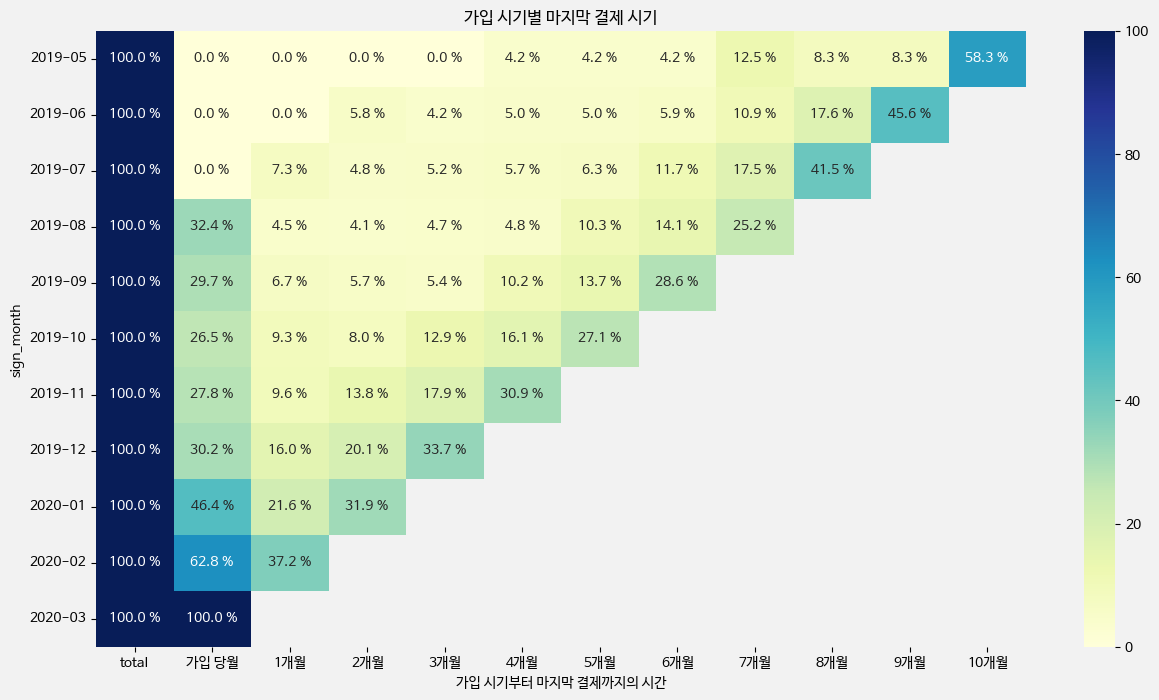

In [ ]:
# import seaborn as sns

# 히트맵 시각화
# xticks = ['total', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
xticks = ['total', '가입 당월', '1개월', '2개월', '3개월', '4개월', '5개월', '6개월', '7개월', '8개월', '9개월', '10개월']
yticks = cohort_df['sign_month'].sort_values().unique().tolist()


plt.figure(figsize = (15, 8), facecolor='#f2f2f2')
ax = sns.heatmap(customer_cohort, 
                annot=True, 
                xticklabels=xticks,
                yticklabels=yticks, 
                fmt='.1f',
                cmap='YlGnBu')
for t in ax.texts: t.set_text(t.get_text() + " %")
sns.set_style(rc = {'axes.facecolor': '#f2f2f2', 'figure.facecolor':'#f2f2f2'})
plt.title('가입 시기별 마지막 결제 시기')
plt.xlabel('가입 시기부터 마지막 결제까지의 시간')
plt.yticks(rotation=0)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 [Text(0, 0.5, '2019-05'),
  Text(0, 1.5, '2019-06'),
  Text(0, 2.5, '2019-07'),
  Text(0, 3.5, '2019-08'),
  Text(0, 4.5, '2019-09'),
  Text(0, 5.5, '2019-10'),
  Text(0, 6.5, '2019-11'),
  Text(0, 7.5, '2019-12'),
  Text(0, 8.5, '2020-01'),
  Text(0, 9.5, '2020-02'),
  Text(0, 10.5, '2020-03')])

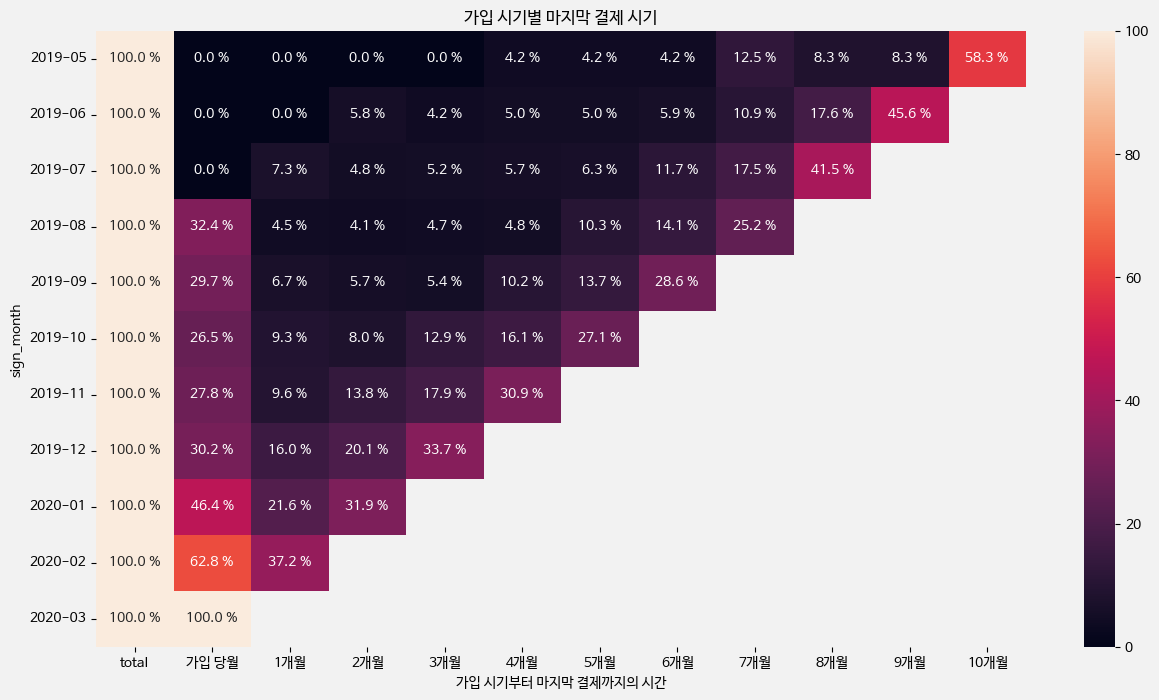

In [ ]:
# import seaborn as sns

# 히트맵 시각화
# xticks = ['total', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
xticks = ['total', '가입 당월', '1개월', '2개월', '3개월', '4개월', '5개월', '6개월', '7개월', '8개월', '9개월', '10개월']
yticks = cohort_df['sign_month'].sort_values().unique().tolist()


plt.figure(figsize = (15, 8), facecolor='#f2f2f2')
ax = sns.heatmap(customer_cohort, 
                annot=True, 
                xticklabels=xticks,
                yticklabels=yticks, 
                fmt='.1f',
                #cmap='PuRd'
                )
for t in ax.texts: t.set_text(t.get_text() + " %")
sns.set_style(rc = {'axes.facecolor': '#f2f2f2', 'figure.facecolor':'#f2f2f2'})
plt.title('가입 시기별 마지막 결제 시기')
plt.xlabel('가입 시기부터 마지막 결제까지의 시간')
plt.yticks(rotation=0)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 [Text(0, 0.5, '2019-05'),
  Text(0, 1.5, '2019-06'),
  Text(0, 2.5, '2019-07'),
  Text(0, 3.5, '2019-08'),
  Text(0, 4.5, '2019-09'),
  Text(0, 5.5, '2019-10'),
  Text(0, 6.5, '2019-11'),
  Text(0, 7.5, '2019-12'),
  Text(0, 8.5, '2020-01'),
  Text(0, 9.5, '2020-02'),
  Text(0, 10.5, '2020-03')])

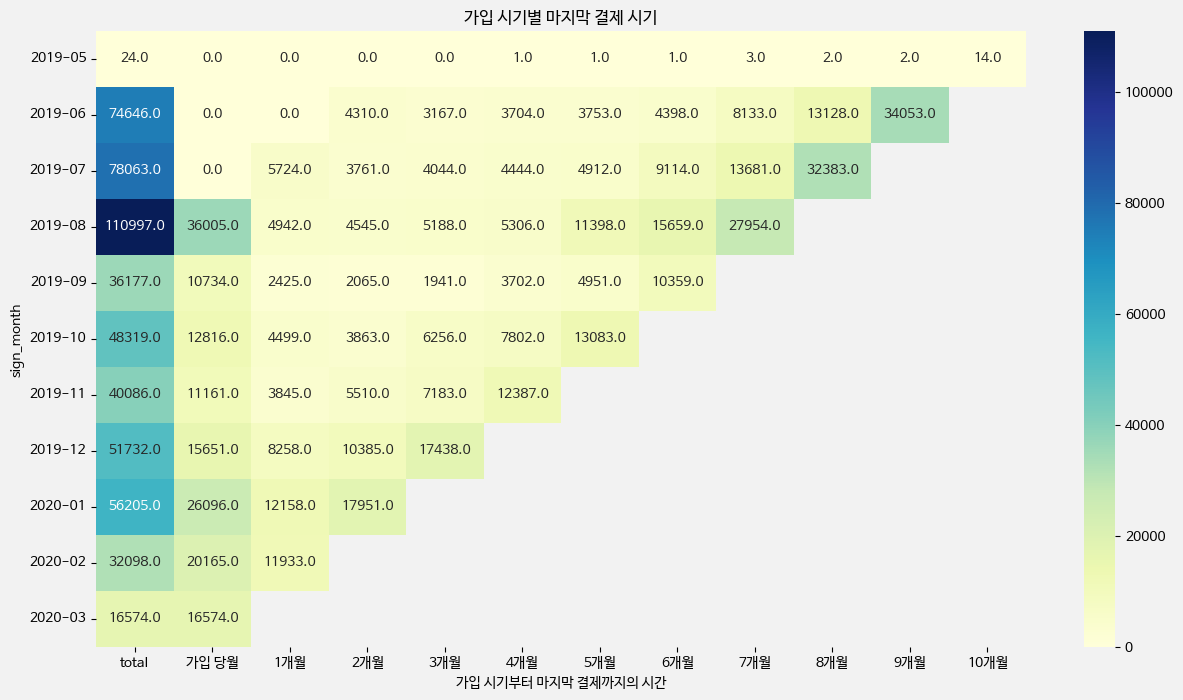

In [ ]:
# import seaborn as sns

# 히트맵 시각화
# xticks = ['total', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
xticks = ['total', '가입 당월', '1개월', '2개월', '3개월', '4개월', '5개월', '6개월', '7개월', '8개월', '9개월', '10개월']
yticks = cohort_df['sign_month'].sort_values().unique().tolist()


plt.figure(figsize = (15, 8), facecolor='#f2f2f2')
sns.heatmap(customer_cohort, 
            annot=True, 
            xticklabels=xticks,
            yticklabels=yticks, 
            fmt='.1f%',
            cmap='YlGnBu')
sns.set_style(rc = {'axes.facecolor': '#f2f2f2', 'figure.facecolor':'#f2f2f2'})
plt.title('가입 시기별 마지막 결제 시기')
plt.xlabel('가입 시기부터 마지막 결제까지의 시간')
plt.yticks(rotation=0)

